In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

Dataset Contents
- u.data: 100,000 ratings by 943 users on 1,682 movies
- u.item: Movie metadata (title, release date, genre flags)
- u.user: User metadata (age, gender, occupation, zip)
- Format: Tab-separated values

In [2]:
import pandas as pd

# Load ratings
ratings_cols = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv('../data/ml-100k/u.data', sep='\t', names=ratings_cols)

# Load movies
movies_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] + [f'genre_{i}' for i in range(19)]
movies = pd.read_csv('../data/ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Load users
users_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv('../data/ml-100k/u.user', sep='|', names=users_cols)


In [3]:
# Ratings + Movie info
ratings_movies = ratings.merge(movies[['item_id', 'title']], on='item_id')

# Ratings + Movie + User info
full_df = ratings_movies.merge(users, on='user_id')


In [5]:
print(full_df.shape)
full_df.head()

(100000, 9)


,user_id,item_id,rating,timestamp,title,age,gender,occupation,zip_code
0,196,242,3,881250949,Kolya (1996),49,M,writer,55105
1,186,302,3,891717742,L.A. Confidential (1997),39,F,executive,00000
2,22,377,1,878887116,Heavyweights (1994),25,M,writer,40206
3,244,51,2,880606923,Legends of the Fall (1994),28,M,technician,80525
4,166,346,1,886397596,Jackie Brown (1997),47,M,educator,55113


# Exploratory Data Analysis

## Most rated movies

In [35]:
temp_df = pd.DataFrame(ratings_movies.groupby('title')['rating'].count().sort_values(ascending=False).head(20))
temp_df.reset_index(inplace=True)

In [36]:
temp_df

,title,rating
0,Star Wars (1977),583
1,Contact (1997),509
2,Fargo (1996),508
3,Return of the Jedi (1983),507
4,Liar Liar (1997),485
5,"English Patient, The (1996)",481
6,Scream (1996),478
7,Toy Story (1995),452
8,Air Force One (1997),431
9,Independence Day (ID4) (1996),429


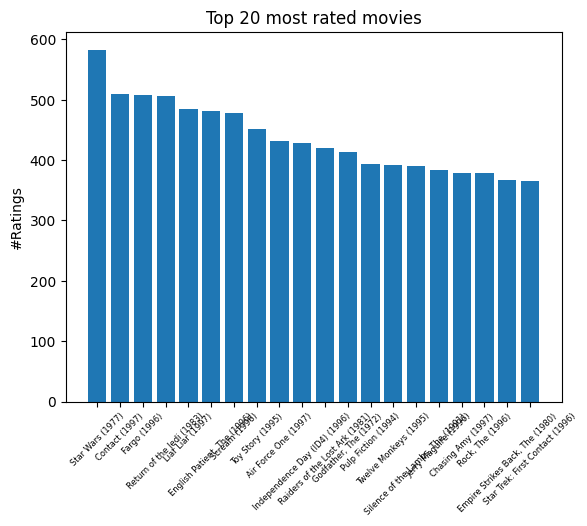

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.bar(temp_df['title'], temp_df['rating'])

ax.set_ylabel('#Ratings')
ax.set_title('Top 20 most rated movies')
plt.xticks(rotation=45,fontsize = 6)
plt.show()

## Average rating per movie

In [31]:
temp_df = pd.DataFrame(ratings_movies.groupby('title')['rating'].mean().sort_values(ascending=False).head(20))
temp_df.reset_index(inplace=True)

In [32]:
temp_df

,title,rating
0,They Made Me a Criminal (1939),5.000000
1,Marlene Dietrich: Shadow and Light (1996),5.000000
2,"Saint of Fort Washington, The (1993)",5.000000
3,Someone Else's America (1995),5.000000
4,Star Kid (1997),5.000000
5,"Great Day in Harlem, A (1994)",5.000000
6,Aiqing wansui (1994),5.000000
7,Santa with Muscles (1996),5.000000
8,Prefontaine (1997),5.000000
9,Entertaining Angels: The Dorothy Day Story (1996),5.000000


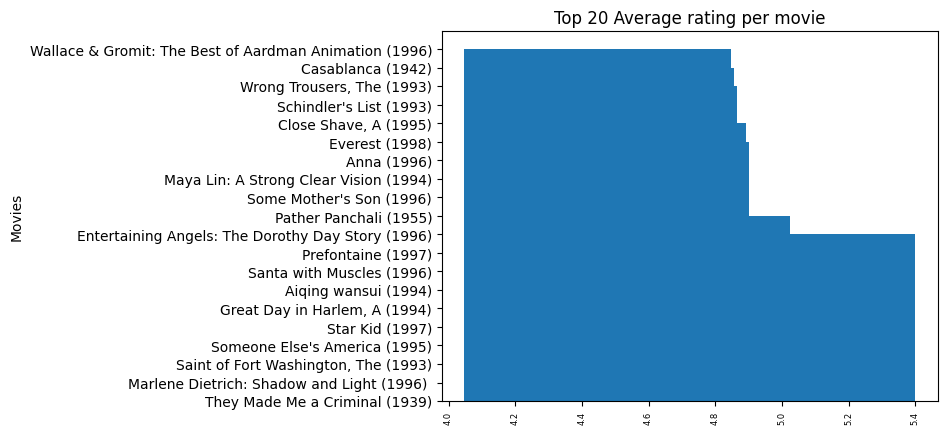

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.bar(temp_df['rating'], temp_df['title'])

ax.set_ylabel('Movies')
ax.set_title('Top 20 Average rating per movie')
plt.xticks(rotation=90,fontsize=6)
plt.show()

## Rating Distribution

<Axes: >

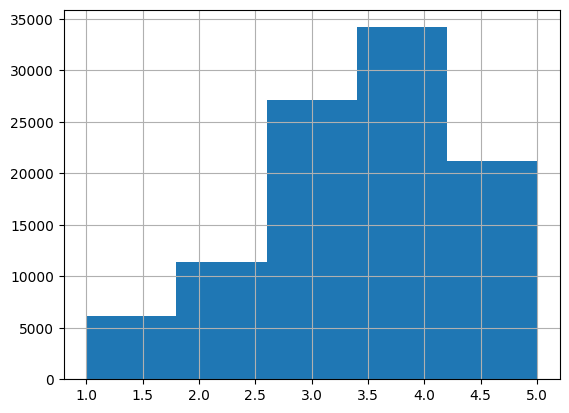

In [40]:
import matplotlib.pyplot as plt
ratings['rating'].hist(bins=5)


## Rating per user

In [41]:
ratings['user_id'].value_counts().describe()

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: count, dtype: float64

# Collaborative Filtering

## LightFM Model (explicit ratings)

In [52]:
from lightfm import LightFM
from lightfm.data import Dataset as LFMData
from scipy.sparse import coo_matrix
import numpy as np

# Reuse ratings from above
ratings['user_id'] = ratings['user_id'].astype(str)
ratings['item_id'] = ratings['item_id'].astype(str)
movies['item_id'] = movies['item_id'].astype(str)

# Build user-item interaction matrix
lfm_data = LFMData()
lfm_data.fit(ratings['user_id'], ratings['item_id'])

(interactions, weights) = lfm_data.build_interactions([
    (row['user_id'], row['item_id'], row['rating']) for _, row in ratings.iterrows()
])

# Train model
model = LightFM(loss='warp')  # Or 'logistic', 'bpr', 'warp-kos'
model.fit(interactions, epochs=10, num_threads=2)

# Predict: Top-N for user 196
user_id = 196
n_users, n_items = interactions.shape

scores = model.predict(user_id, np.arange(n_items))
top_items = np.argsort(-scores)[:5]

# Mapping back to item IDs
item_id_map, _ = lfm_data.mapping()[1], lfm_data.mapping()[0]
inv_item_map = {v: k for k, v in item_id_map.items()}
recommended_items = [inv_item_map[i] for i in top_items]
recommended_titles = movies[movies['item_id'].isin(recommended_items)]

print("Top movie recommendations for user 196:\n")
print(recommended_titles[['item_id', 'title']].to_string(index=False))

Top movie recommendations for user 196:

item_id                         title
     21 Muppet Treasure Island (1996)
     60     Three Colors: Blue (1993)
     77              Firm, The (1993)
     82          Jurassic Park (1993)
    658     Pump Up the Volume (1990)
